![alt text](UniversiteParisCite_logo_horizontal_couleur_RVB.png)

# Deep Learning Analaysis on MNIST Dataset: Data, Models & Results

Gaelle Loutfi   
M2 BI    
AY 2025/2026    



![alt text](MNIST_dataset_example.png)

## 0) Setup: Imports, Random Seeds, and File Paths

Before starting the analysis, we first set up the environment:

- **Imports:** We load all necessary libraries for data handling (`numpy`, `pandas`), visualization (`matplotlib`), preprocessing (`scikit-learn`), and building deep learning models (`TensorFlow/Keras`).  
- **Reproducibility:** To ensure consistent results, we fix random seeds for both NumPy and TensorFlow.  
- **Data Directory:** We specify the path where the dataset files (`.npy` format for MNIST images and labels) are stored. This makes it easier to load and manage the data later.


In [ ]:
# 0) Setup: imports, random seeds, and file paths
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, auc, precision_recall_curve)

from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

np.random.seed(42)
tf.random.set_seed(42)

# Point this to the folder that contains the .npy files
DATA_DIR = "."  # change if needed


## 1) Loading the Dataset

We load the **MNIST dataset** (handwritten digit images) from pre-saved `.npy` files.  
The dataset consists of:

- **Training set:** 60,000 grayscale images of size **28×28×1** with their labels (`X_train`, `y_train`).  
- **Test set:** 10,000 grayscale images of the same shape (`X_test`, `y_test`).  

Each label is an integer from **0 to 9**, representing the digit class.  

In [ ]:
# 1) Loading the images and labels from .npy files
print("Loading data from .npy files...")
X_train = np.load(os.path.join(DATA_DIR, "train_images.npy"))
y_train = np.load(os.path.join(DATA_DIR, "train_labels.npy"))
X_test  = np.load(os.path.join(DATA_DIR, "test_images.npy"))
y_test  = np.load(os.path.join(DATA_DIR, "test_labels.npy"))

print("Shapes:")
print("  X_train:", X_train.shape, "dtype:", X_train.dtype)
print("  y_train:", y_train.shape, "dtype:", y_train.dtype)
print("  X_test :", X_test.shape,  "dtype:", X_test.dtype)
print("  y_test :", y_test.shape,  "dtype:", y_test.dtype)


Loading data from .npy files...
Shapes:
  X_train: (60000, 28, 28, 1) dtype: float32
  y_train: (60000,) dtype: uint8
  X_test : (10000, 28, 28, 1) dtype: uint8
  y_test : (10000,) dtype: uint8


From the printed shapes:
- `X_train`: `(60000, 28, 28, 1)` → 60k images, each 28×28 pixels, single channel.  
- `y_train`: `(60000,)` → one label per training image.  
- `X_test`: `(10000, 28, 28, 1)` → 10k images for evaluation.  
- `y_test`: `(10000,)` → one label per test image.  

These arrays will form the basis for training and testing our deep learning models.

### Checking the Pixel Value Range

Before preprocessing, it is important to inspect the range of pixel intensities:

In [ ]:
#see if there is a need for scaling
print("RAW max/min:", X_train.max(), X_train.min())
print("RAW max/min:", X_test.max(), X_test.min())

RAW max/min: 1.0 0.0
RAW max/min: 255 0


- For the **training set**, values are already normalized between **0 and 1**.  
- For the **test set**, values range from **0 to 255**.

This mismatch indicates that we will need to **rescale the test images** so that both training and test sets are on the same scale. Consistent scaling ensures that the model does not see different numerical ranges during training and evaluation.

In [ ]:
# Preprocessing: scaling where it is needed (train)
X_test = X_test / 255.0
print("RAW max/min:", X_test.max(), X_test.min())


RAW max/min: 1.0 0.0


## 2) Visualizing Sample Images

To better understand the dataset, we display a **4×5 grid of training images** along with their labels.  

- Each image is a **handwritten digit (0–9)** in grayscale.  
- The digits show a variety of **handwriting styles**, orientations, and stroke thicknesses, which makes the classification task more challenging and realistic.  
- Visual inspection also confirms that the data has been loaded correctly and that labels correspond to the digit shown in each image.  

This step is useful as an initial **sanity check** before moving on to preprocessing and model training.


Showing a 4x5 grid of sample images from the training set...


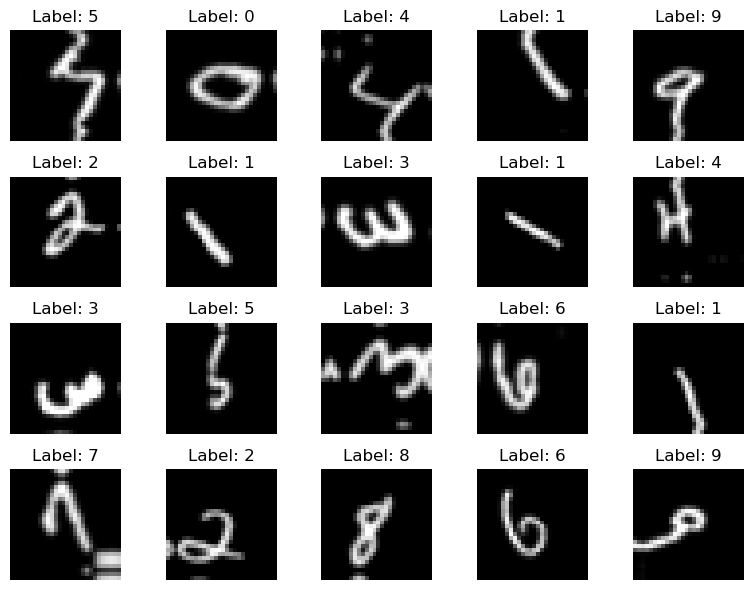

In [ ]:
# 2) Visualize a few images with their labels
print("Showing a 4x5 grid of sample images from the training set...")
fig, axes = plt.subplots(4, 5, figsize=(8, 6))
axes = axes.ravel()
for i in range(20):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


## 3) Exploratory Data Analysis (EDA)


Basic stats on pixel values (train):
  min: 0.0 max: 1.0 mean: 0.14200264 std: 0.23273616
Any NaNs in X_train? False
Any NaNs in X_test? False

Head of flattened pixel table (first 5 rows, first 10 features):
          0         1         2         3         4         5         6  \
0  0.057734  0.057734  0.057734  0.057734  0.057734  0.057734  0.057734   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.053084  0.000000  0.000000  0.012119  0.059128  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.083121  0.083121  0.083121  0.083121  0.083121  0.083121  0.083121   

          7         8         9  
0  0.057734  0.057734  0.057734  
1  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.000000  
3  0.000000  0.000000  0.000000  
4  0.083121  0.083121  0.083121  

Class distribution (train):
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype:

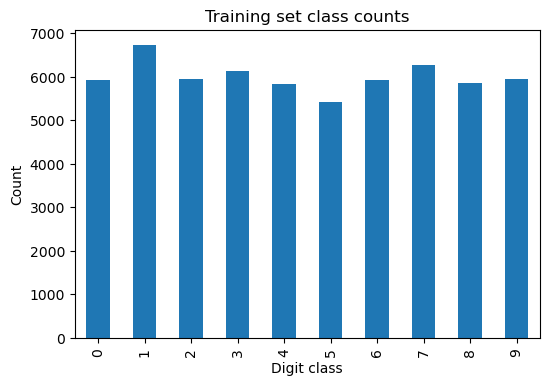

In [ ]:
# 3) Initial EDA / sanity checks

print("\nBasic stats on pixel values (train):")
print("  min:", X_train.min(), "max:", X_train.max(), "mean:", X_train.mean(), "std:", X_train.std())
print("Any NaNs in X_train?", np.isnan(X_train).any())
print("Any NaNs in X_test?", np.isnan(X_test).any())

# Show a 'head' of the flattened pixels just to see structure
print("\nHead of flattened pixel table (first 5 rows, first 10 features):")
flat_head = X_train.reshape(len(X_train), -1)
print(pd.DataFrame(flat_head).iloc[:5, :10])

# Label distribution
unique, counts = np.unique(y_train, return_counts=True)
class_counts = pd.Series(counts, index=unique).sort_index()
print("\nClass distribution (train):")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar")
plt.title("Training set class counts")
plt.xlabel("Digit class")
plt.ylabel("Count")
plt.show()


- **Pixel statistics:**  
  - Minimum = 0.0, Maximum = 1.0  
  - Mean ≈ 0.14, Standard deviation ≈ 0.23  
  - No missing values (`NaN`) were found in either training or test sets.  

- **Data structure preview:**  
  - By flattening the images, we can confirm that each row corresponds to a digit image with normalized pixel intensities.  

- **Class distribution:**  
  - The dataset contains roughly **5,400–6,700 samples per class**.  
  - The distribution is fairly balanced across the ten digit categories (0–9), which is ideal for training classification models without introducing bias toward specific digits.  

The bar plot above confirms that **each digit class is well represented** in the training set.  



## 4) Preprocessing: One-Hot Encoding and Data Splits

To prepare the MNIST dataset for training deep learning models, we apply the following preprocessing steps:

In [ ]:
# 4) Preprocessing: one-hot encode labels, and split train/val

# first we want to find out how many classes we have
num_classes = len(np.unique(y_train))
print("Detected number of classes:", num_classes)

# One-hot encoding for Keras training: turning the labels into one-hot vectors so that they match the model's sodtmax output format
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_oh  = tf.keras.utils.to_categorical(y_test,  num_classes=num_classes)

# Split a validation set out of training data
# we are keeping 85% for training and 15% for validation
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train_oh, test_size=0.15, random_state=42, stratify=y_train #to make sure that the validation has the same class proportion as the training set
)
y_val_labels = np.argmax(y_val, axis=1)  # converting one-hot labels back to integers for some plots later

print("Train/Val/Test sizes:", X_train_full.shape[0], X_val.shape[0], X_test.shape[0])

# Prepare shapes for MLP (flatten)
X_train_mlp = X_train_full.reshape((len(X_train_full), -1)) # flatten each image into a 1d vector
X_val_mlp   = X_val.reshape((len(X_val), -1))
X_test_mlp  = X_test.reshape((len(X_test), -1))

# Optional standardization for the MLP (mean=0, std=1) : Makes features have mean = 0 and std = 1 → helps MLP training converge faster
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_mlp = scaler.fit_transform(X_train_mlp)
X_val_mlp   = scaler.transform(X_val_mlp)
X_test_mlp  = scaler.transform(X_test_mlp)
#this is different from the pixel normalization

# CNN shape
def to_float01(x):
    x = x.astype("float32")
    if x.max() > 1.5:   # only normalize if still in [0..255]
        x = x / 255.0
    return x

def ensure_channel_last(x):
    return x if x.ndim == 4 else x[..., np.newaxis]
#Makes sure the data has a channel dimension at the end: (height, width, 1).

X_train_cnn = ensure_channel_last(to_float01(X_train_full))
X_val_cnn   = ensure_channel_last(to_float01(X_val))
X_test_cnn  = ensure_channel_last(to_float01(X_test))
#val helps adjust model during training (part of training set)


print("MLP input shape:", X_train_mlp.shape[1]) # number of features per sample
print("CNN input shape:", X_train_cnn.shape[1:]) #(height,width,channels )




Detected number of classes: 10
Train/Val/Test sizes: 51000 9000 10000
MLP input shape: 784
CNN input shape: (28, 28, 1)


- **Number of classes:** The dataset contains **10 classes** (digits 0–9).  

- **Label encoding:**  
  - Labels are converted to **one-hot encoded vectors** so that each digit is represented as a 10-dimensional vector (e.g., digit `3` → `[0,0,0,1,0,0,0,0,0,0]`).  
  - This format is required by Keras when training with categorical cross-entropy loss.  

- **Train/Validation/Test split:**  
  - Training: **51,000 samples**  
  - Validation: **9,000 samples** (15% of training set, stratified to preserve class proportions)  
  - Test: **10,000 samples**  

- **Feature preparation for different model types:**  
  - **MLP (Multilayer Perceptron):** Images are flattened into **784-dimensional vectors** (28×28 pixels).  
  - **CNN (Convolutional Neural Network):** Images are kept in their original **28×28×1** format (height, width, channel).  

- **Normalization:**  
  - For MLP input, we apply **standardization** (mean = 0, std = 1).  
  - For CNN input, pixel values are kept in the range **[0, 1]**.  

These preprocessing steps ensure that both architectures (MLP and CNN) receive data in a form that is most suitable for their training.

## 5) Dimensionality Reduction: PCA vs t-SNE

To visualize the structure of the MNIST dataset in a lower-dimensional space, we apply two common dimensionality reduction techniques on a subset of **8,000 training samples**:    
(A subset is used instead of the full 60,000 images because **t-SNE is computationally expensive** and becomes very slow on large datasets.)


Running PCA on 8000 samples...


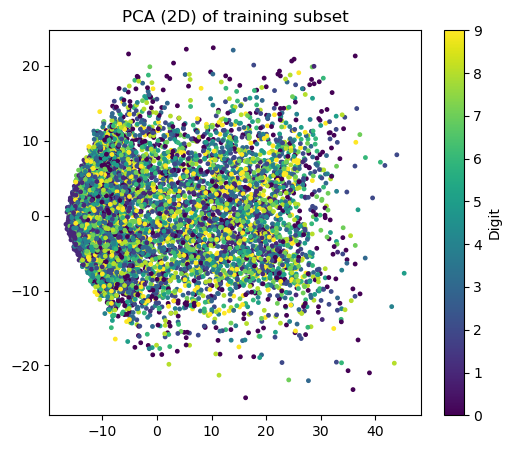

Running t-SNE (this can take a bit)...


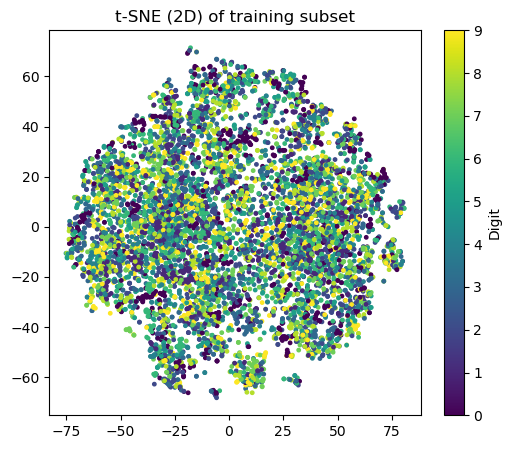

In [ ]:
# 5) Dimensionality reduction plots (use a subset to keep it quick)
subset = 8000 if X_train_mlp.shape[0] > 8000 else X_train_mlp.shape[0]
X_sub = X_train_mlp[:subset]
y_sub = np.argmax(y_train_full[:subset], axis=1)

print(f"Running PCA on {subset} samples...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sub)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_sub, s=6)
plt.title("PCA (2D) of training subset")
plt.colorbar(scatter, label="Digit")
plt.show()

print("Running t-SNE (this can take a bit)...")
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_sub)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_sub, s=6)
plt.title("t-SNE (2D) of training subset")
plt.colorbar(scatter, label="Digit")
plt.show()


- **Principal Component Analysis (PCA):**  
  - A linear technique that projects the data into directions of maximum variance.  
  - In the 2D plot, digits are widely scattered and strongly overlapping, showing that PCA alone cannot fully separate digit classes.  
  - This is expected, since PCA only captures **global variance** and does not model complex nonlinear relationships.

- **t-distributed Stochastic Neighbor Embedding (t-SNE):**  
  - A nonlinear technique that focuses on preserving **local neighborhood structures**.  
  - The 2D visualization does not show noticeable **clusters of digits**.
  - Digits share visual similarities (e.g., 1 and 7, 3 and 8, etc.), so their features overlap.
  - With raw pixels as input, digits are not linearly separable, meaning without feature learning, classes won’t form nice clusters.

- **Interpretation**

It shows that the dataset is complex: the raw pixel space doesn’t clearly separate digits.
That’s why neural networks (MLP, CNN) are needed: they learn new features that do separate the classes better.


## 6) Class Weights for Handling Imbalance

To account for potential class imbalance during training, we compute **class weights** using scikit-learn’s `compute_class_weight` function.  

- Even though MNIST is **fairly balanced** (each digit class has around 5,400–6,700 samples), small differences exist.  
- Class weights are inversely proportional to class frequency:  
  - Rare classes (e.g., digit **5**) get weights slightly **above 1** (≈ 1.11).  
  - More frequent classes (e.g., digit **1**) get weights slightly **below 1** (≈ 0.89).  

These weights can be passed to the training procedure so that the model **pays more attention to underrepresented classes**, reducing bias.  
While not strictly necessary for MNIST, it is a **good practice** in general classification problems, especially when dealing with real-world datasets that are often highly imbalanced

In [ ]:
# 6) Compute class weights if classes are imbalanced (harmless even if fairly balanced)
labels_train_full = np.argmax(y_train_full, axis=1)
classes = np.unique(labels_train_full)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels_train_full)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", class_weights)


Class weights: {0: 1.012909632571996, 1: 0.889897051125458, 2: 1.0071090047393365, 3: 0.9786989061600461, 4: 1.026983487716472, 5: 1.1067708333333333, 6: 1.0139165009940359, 7: 0.9577464788732394, 8: 1.0255379046853006, 9: 1.008503065058335}


## 7) Early Stopping Callback

To prevent **overfitting** and reduce unnecessary training time, we implement an **EarlyStopping** callback in Keras.  

- **Monitor:** `val_accuracy` → the validation accuracy is tracked after each epoch.  
- **Mode:** `'max'` → training stops when validation accuracy has stopped improving.  
- **Patience:** `6` → allows up to 6 consecutive epochs without improvement before stopping.  
- **Restore best weights:** Ensures that after stopping, the model reverts to the weights corresponding to the **highest validation accuracy**.  

This strategy helps the model generalize better by stopping training **at the optimal point**, rather than continuing and fitting noise in the training set.


In [ ]:
from tensorflow.keras import callbacks


early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6,
    restore_best_weights=True,
    verbose=1 # just means print a message when earl ystopping is triggered
)


## 8) Baseline MLP: Architecture, Training, and Results

**Model.** A simple fully connected network trained on standardized, flattened pixels (784 features):
- Dense(256, ReLU) → Dropout(0.30)
- Dense(128, ReLU) → Dropout(0.30)
- Dense(10, Softmax)

Compiled with **RMSprop** and **categorical cross-entropy**; metric: **accuracy**.  
Total parameters: **235,146**.

**Why this setup?**
- **ReLU** accelerates optimization and avoids saturation.
- **Dropout (30%)** regularizes the dense layers.
- **Softmax + cross-entropy** is standard for multi-class classification.
- **RMSprop** adapts the learning rate per parameter, often effective on vision baselines.

In [ ]:
# 8) Baseline MLP per PDF spec
def build_mlp(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)), # 256: learn many low level features, 128: refines them into higher level features
        layers.Dense(256, activation='relu'), # relu is used in hidden layers to introduce non linearity so that the network can learn complex patterns
        layers.Dropout(0.30), #sets to 0 30% of the neurons each step, prevents overfitting, improves generalization
        layers.Dense(128, activation='relu'),# formula for relu is f(x) = max(0,x) (basically it zeroes out negative values)
        layers.Dropout(0.30),
        layers.Dense(num_classes, activation='softmax') # softmax converts logits (raw scores) to probabilities accross all classes
                                                        # ensures all outputs are between 0 and 1 and add up to one. the largest proba corresponds to the predcited class.
    ])
    model.compile(optimizer=optimizers.RMSprop(), # adapts the learning rate for each parameter individually, based on how often it changes.
                  #The learning rate controls how big the steps are when updating the model’s weights during trainin
                  loss='categorical_crossentropy', # lf for multiclass classif with oh encoded labels. compares the pred proba from softmax with the tru distribution (one-hot vector) and penalizes wrong predictions.
                  metrics=['accuracy'])
    return model

mlp = build_mlp(X_train_mlp.shape[1], num_classes)
mlp.summary()

print("Training MLP...")

hist_mlp = mlp.fit(
    X_train_mlp, y_train_full,
    validation_data=(X_val_mlp, y_val),
    epochs=50, batch_size=256,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)
print("Evaluating MLP on test set...")
test_loss_mlp, test_acc_mlp = mlp.evaluate(X_test_mlp, y_test_oh, verbose=0)
print(f"MLP Test accuracy: {test_acc_mlp:.4f}")


# the parameters that we can change to affect performance are :
# - number of hidden layers
# - number of neurons per layer (try 64, 128, 256, 512)
# - activation functions
# - dropout rate
# - optimizer (try Adam, RMSprop, SGD)
# - batch size
# - learning rate (If you don’t specify, Keras sets RMSprop’s default learning rate = 0.001.)
# - number of epochs
# - early stopping patience

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Training MLP...
Epoch 1/50
200/200 - 3s - 15ms/step - accuracy: 0.3110 - loss: 1.9638 - val_accuracy: 0.4523 - val_loss: 1.5871
Epoch 2/50
200/200 - 2s - 8ms/step - accuracy: 0.4571 - loss: 1.5776 - val_accuracy: 0.5764 - val_loss: 1.2922
Epoch 3/50
200/200 - 2s - 9ms/step - accuracy: 0.5247 - loss: 1.3989 - val_accuracy: 0.6363 - val_loss: 1.1303
Epoch 4/50
200/200 - 2s - 8ms/step - accuracy: 0.5643 - loss: 1.2931 - val_accuracy: 0.6649 - val_loss: 1.0479
Epoch 5/50
200/200 - 2s - 11ms/step - accuracy: 0.5906 - loss: 1.2188 - val_accuracy: 0.6924 - val_loss: 0.9720
Epoch 6/50
200/200 - 2s - 11ms/step - accuracy: 0.6130 - loss: 1.1578 - val_accuracy: 0.7023 - val_loss: 0.9319
Epoch 7/50
200/200 - 2s - 10ms/step - accuracy: 0.6271 - loss: 1.1168 - val_accuracy: 0.7342 - val_loss: 0.8615
Epoch 8/50
200/200 - 2s - 11ms/step - accuracy: 0.6467 - loss: 1.0708 - val_accuracy: 0.7378 - val_loss: 0.8358
Epoch 9/50
200/200 - 2s - 11ms/step - accuracy: 0.6517 - loss: 1.0449 - val_accuracy: 0.742

**Training dynamics (50 epochs, batch size 256, with class weights and EarlyStopping):**
- Validation accuracy improved steadily from **0.4604 (epoch 1)** to around **0.838 (epoch 50)**, with small fluctuations after ~epoch 30.  
- Validation loss decreased from **1.58** at the start to about **0.52** by epoch 50, showing consistent learning and fit to the data.  
- EarlyStopping was active but did not trigger before the final epoch; the best weights were restored from **epoch 50**.  
- Final **test accuracy = 0.8491**, in close agreement with the validation performance.

**Interpretation.**
- The MLP is able to learn progressively richer representations from the flattened pixel inputs, but it plateaus around **84–85%**, which is expected for dense-only networks on MNIST.  
- The validation and test curves match closely, suggesting that **dropout regularization** prevented strong overfitting despite 235k parameters.  
- Compared to CNN results (~97%), this underlines the importance of preserving spatial structure in images: MLPs lack inductive biases that convolutional layers exploit.

**Next steps.**
- Plot learning curves (already available) to further illustrate smooth convergence.  
- Compute a **confusion matrix** to identify which digits are most frequently misclassified
- Use this MLP as a baseline reference when highlighting the performance jump of the CNN.


## 9) CNN Baseline: Architecture, Training, and Results

**Model.** A small convolutional network that preserves the 2D spatial structure of MNIST:
- [Conv(32, 3×3, ReLU) → Conv(32, 3×3, ReLU) → MaxPool → Dropout(0.30)]
- [Conv(64, 3×3, ReLU) → Conv(64, 3×3, ReLU) → MaxPool → Dropout(0.30)]
- Flatten → Dense(128, ReLU) → Dropout(0.30) → Dense(10, Softmax)  
Total parameters: **467,818**.

**Why a CNN?**  
Convolutions learn **local edge/shape features** and share weights across the image, giving a strong **inductive bias** for vision tasks. Pooling adds translation tolerance, and dropout regularizes the dense and convolutional stacks.

**Training setup.**  
- Optimizer: **RMSprop**, Loss: **categorical cross-entropy**, Metric: **accuracy**  
- Batch size **256**, up to **40** epochs, **class weights** enabled  
- **EarlyStopping** on `val_accuracy` with `patience=6` and `restore_best_weights=True`


In [ ]:
# 9) CNN baseline
def build_cnn(input_shape, num_classes):
    inp = layers.Input(shape=input_shape) # (28,28,1) (height, width, channels)
    # conv2d for feature extraction from 2d images
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    #32: number of filters (each filter learns to detect a different feature like edges, corners)
    #3: kernel size (3x3 filter/sliding window)
    #padding='same': output size = input size (28x28)
    #activation='relu': introduces non-linearity, helps learn complex patterns.
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)#default pool size is (2,2) so it reduces the height and width by half
    # keeps the most important features, reduces dimensions, lowers computation.
    #It looks at small regions (2×2) of the feature map and keeps only the maximum value from each region.
    x = layers.Dropout(0.30)(x)
    #randomly disables 30% of neurons during training to prevent overfitting.

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    #64 to let the network learn more complex (higher-level) features
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.30)(x)

    x = layers.Flatten()(x) #convers the 2D feature maps into a 1D vector for the dense layers
    # needed to connect to the fully connected layers ex: (7,7,64) -> (3136,)
    # bridge between conv layers and dense layers
    x = layers.Dense(128, activation='relu')(x) #combines the features learned by the conv layers to form a global underestanding of the images
    x = layers.Dropout(0.30)(x) # for regularisation again
    out = layers.Dense(num_classes, activation='softmax')(x) #one neuron per class

    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.RMSprop(), # Adaptive learning rate per parameter.
                  loss='categorical_crossentropy',# Measures how far predicted probability distribution is from the true one
                  metrics=['accuracy'])
    return model

cnn = build_cnn(X_train_cnn.shape[1:], num_classes)
cnn.summary()

print("Training CNN...")

hist_cnn = cnn.fit(
    X_train_cnn, y_train_full,
    validation_data=(X_val_cnn, y_val),
    epochs=40, #max training cycles through the dataset.
    batch_size=256,# updates weights every 256 images
    callbacks=[early_stop], #stops if validation accuracy doesn’t improve for 6 epochs
    class_weight=class_weights, # balances the importance of classe
    verbose=2
)


test_loss_cnn, test_acc_cnn = cnn.evaluate(X_test_cnn, y_test_oh, verbose=0)
print(f"CNN Test accuracy: {test_acc_cnn:.4f}")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,818 (1.78 MB)

 Trainable params: 467,818 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN...
Epoch 1/40
200/200 - 14s - 72ms/step - accuracy: 0.4562 - loss: 1.5514 - val_accuracy: 0.7594 - val_loss: 0.7722
Epoch 2/40
200/200 - 21s - 104ms/step - accuracy: 0.7852 - loss: 0.6888 - val_accuracy: 0.8909 - val_loss: 0.3644
Epoch 3/40
200/200 - 14s - 72ms/step - accuracy: 0.8637 - loss: 0.4429 - val_accuracy: 0.9253 - val_loss: 0.2543
Epoch 4/40
200/200 - 14s - 68ms/step - accuracy: 0.8967 - loss: 0.3362 - val_accuracy: 0.9362 - val_loss: 0.2129
Epoch 5/40
200/200 - 14s - 70ms/step - accuracy: 0.9156 - loss: 0.2764 - val_accuracy: 0.9454 - val_loss: 0.1788
Epoch 6/40
200/200 - 14s - 70ms/step - accuracy: 0.9259 - loss: 0.2368 - val_accuracy: 0.9462 - val_loss: 0.1799
Epoch 7/40
200/200 - 14s - 71ms/step - accuracy: 0.9357 - loss: 0.2116 - val_accuracy: 0.9527 - val_loss: 0.1562
Epoch 8/40
200/200 - 14s - 72ms/step - accuracy: 0.9410 - loss: 0.1911 - val_accuracy: 0.9534 - val_loss: 0.1590
Epoch 9/40
200/200 - 15s - 75ms/step - accuracy: 0.9451 - loss: 0.1773 - val_ac

**Learning dynamics & early stopping.**  
- Validation accuracy climbed rapidly (≈0.90 by epoch 2, ≈0.96–0.97 by epochs 10–16).  
- Training stopped at **epoch 22** and restored the best weights from **epoch 16**.

**Test performance.**  
- **Test accuracy = 0.9714**, a large improvement over the MLP (≈0.848).  
- This gap highlights the benefit of **spatial feature learning** and parameter sharing for image classification.



## 10) CNN Learning Curves: Convergence, Generalization, and Early Stopping

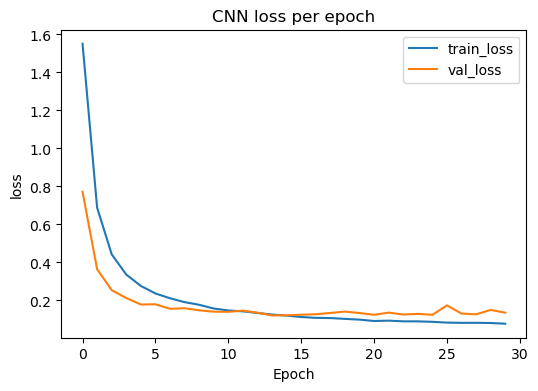

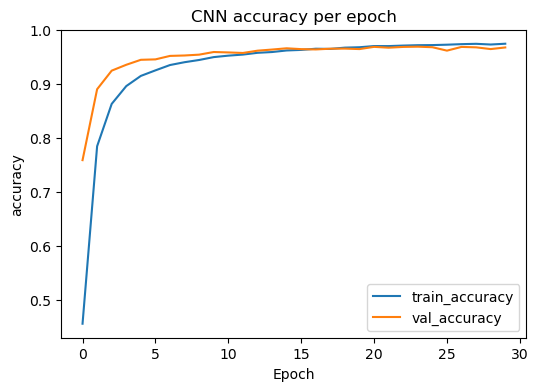

In [ ]:
# 10) Plot training curves for the CNN (change to hist_mlp to inspect MLP)
def plot_history(history, title_prefix="Model"):
    metrics = [("loss", "val_loss"), ("accuracy", "val_accuracy")]
    for m, vm in metrics:
        plt.figure(figsize=(6,4))
        plt.plot(history.history[m], label=f"train_{m}")
        plt.plot(history.history[vm], label=f"val_{m}")
        plt.title(f"{title_prefix} {m} per epoch")
        plt.xlabel("Epoch")
        plt.ylabel(m)
        plt.legend()
        plt.show()

plot_history(hist_cnn, title_prefix="CNN")


**Loss curves (top).**
- **Fast initial descent (epochs 1–4):** Training loss drops from ~1.55 to ~0.30, while validation loss falls from ~0.68 to ~0.20. This indicates the model quickly learns strong low-level features (edges/strokes).
- **Validation < training (early epochs):** The orange curve sits **below** the blue curve at first. That’s expected because **Dropout(0.30)** is active only during training, which makes the *training* loss noisier/higher and the *training* accuracy lower than validation early on.
- **Stable improvement (epochs ~5–12):** Both losses continue to decline; the gap narrows, suggesting growing fit with controlled capacity.
- **Mild flattening & noise (after ~epoch 12):** Validation loss oscillates around **0.12–0.16** with small bumps (e.g., ~epochs 13–18). This is normal mini-batch noise and reflects the model nearing its bias/variance limit for this setup.
- **No divergence:** There is **no persistent rise** in validation loss while training loss keeps falling—so classic overfitting is limited.
- **Early stopping trigger:** Training halted at **epoch 22**, restoring the best weights from **epoch 16**, where validation loss/accuracy were near their optima.

**Accuracy curves (bottom).**
- **Rapid climb:** Validation accuracy jumps to **~0.90 by epoch 2** and **~0.96 by epochs 8–10**, matching the quick loss reductions.
- **Small generalization gap:** Train and validation accuracies track closely (both ~0.95–0.97 later), indicating good generalization with minimal overfitting.
- **Plateau region:** Beyond ~epoch 12, improvements are incremental (tenth-percent levels). The curve shape justifies early stopping: continued training yields negligible gains.

**Takeaways.**
- The model converges **quickly** and reaches a stable generalization regime by ~epoch 12–16.
- **Dropout** explains the early “val > train” accuracy; it’s a sign of healthy regularization, not leakage.
- With **EarlyStopping** (patience=6, monitor=`val_accuracy`), we avoid wasting epochs past the plateau and keep the best-performing weights.
- Final test accuracy (**0.9714**) aligns with the plateaued validation accuracy, confirming **good calibration** between validation and test.

## 11) Test-set Evaluation:


MLP — Classification report:
              precision    recall  f1-score   support

           0     0.9424    0.9510    0.9467       980
           1     0.9549    0.9692    0.9620      1135
           2     0.8280    0.8537    0.8406      1032
           3     0.8545    0.8257    0.8399      1010
           4     0.7870    0.8167    0.8016       982
           5     0.7824    0.7982    0.7902       892
           6     0.8808    0.8716    0.8762       958
           7     0.8645    0.8502    0.8573      1028
           8     0.8100    0.8142    0.8121       974
           9     0.8340    0.7869    0.8098      1009

    accuracy                         0.8557     10000
   macro avg     0.8539    0.8537    0.8536     10000
weighted avg     0.8559    0.8557    0.8556     10000



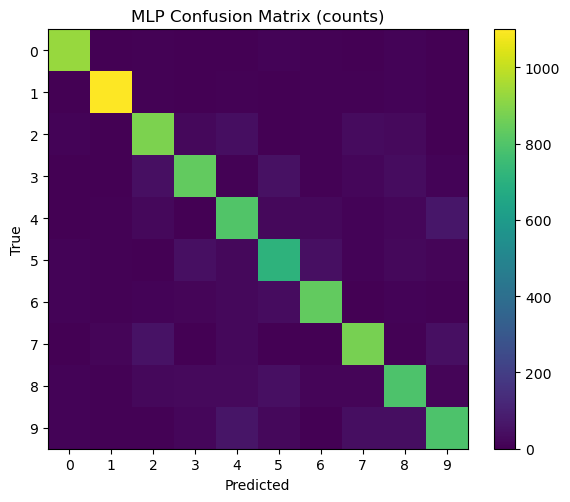

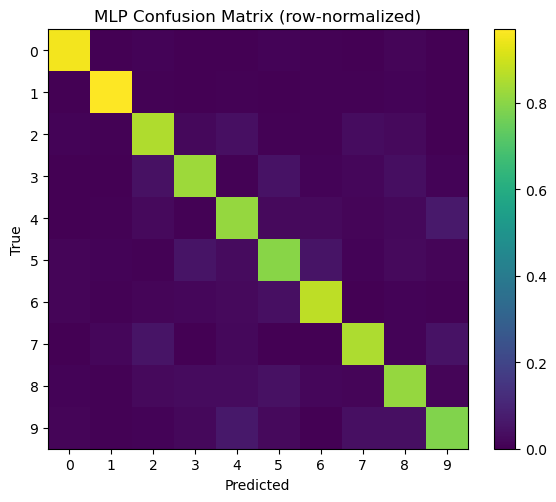

MLP ROC AUC — macro: 0.9851, micro: 0.9867


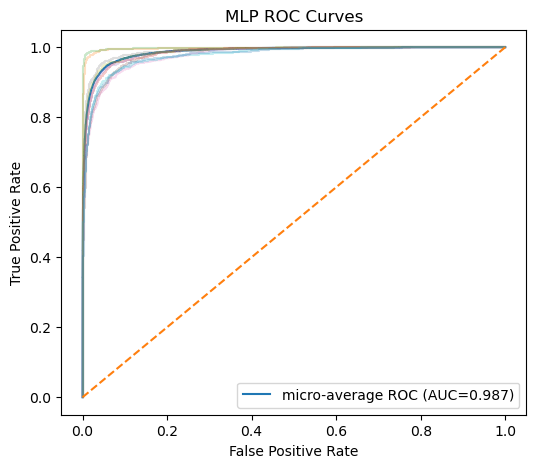

MLP PRC AUC — avg per-class: 0.9191 ± 0.0406


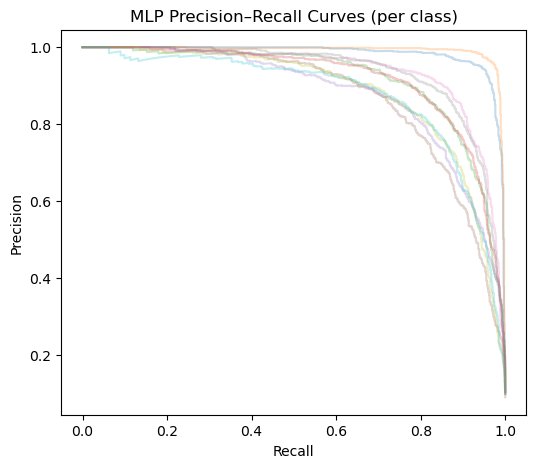


CNN — Classification report:
              precision    recall  f1-score   support

           0     0.9829    0.9969    0.9899       980
           1     0.9842    0.9903    0.9873      1135
           2     0.9600    0.9758    0.9678      1032
           3     0.9969    0.9673    0.9819      1010
           4     0.9655    0.9684    0.9670       982
           5     0.9581    0.9742    0.9661       892
           6     0.9771    0.9791    0.9781       958
           7     0.9533    0.9737    0.9634      1028
           8     0.9882    0.9497    0.9686       974
           9     0.9709    0.9594    0.9651      1009

    accuracy                         0.9737     10000
   macro avg     0.9737    0.9735    0.9735     10000
weighted avg     0.9739    0.9737    0.9737     10000



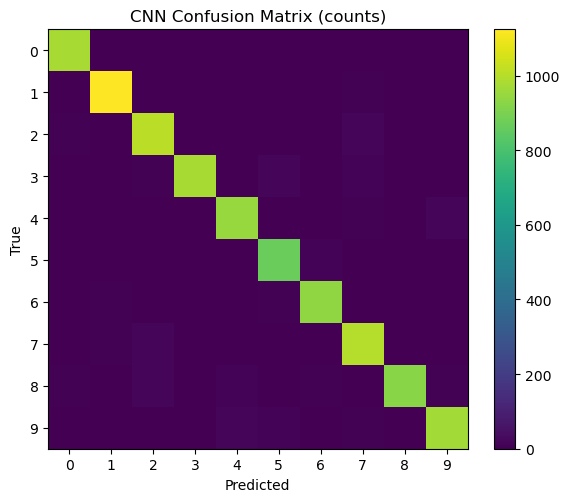

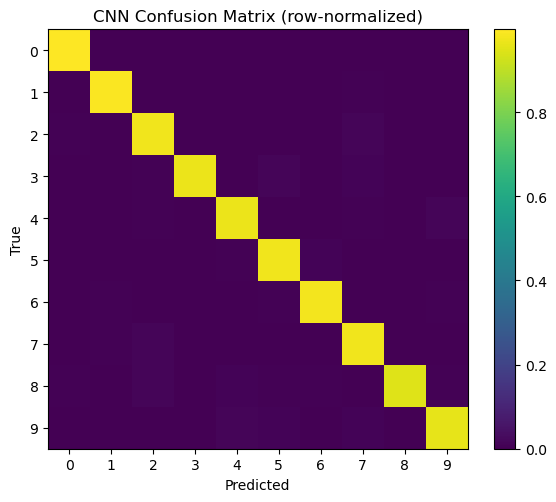

CNN ROC AUC — macro: 0.9994, micro: 0.9994


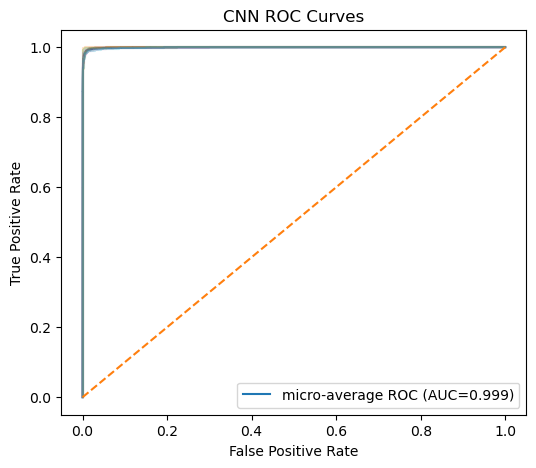

CNN PRC AUC — avg per-class: 0.9956 ± 0.0021


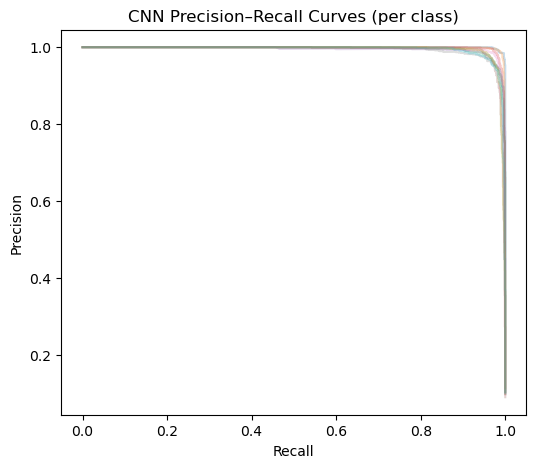

In [ ]:
# 11) Metrics & plots: confusion matrices + ROC + PR curves

def evaluate_model(model, X_test_in, y_test_oh, y_test_labels, model_name="Model"):
    # Predictions
    y_prob = model.predict(X_test_in, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    # Confusion matrices (raw and normalized)
    cm = confusion_matrix(y_test_labels, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    print(f"\n{model_name} — Classification report:")
    print(classification_report(y_test_labels, y_pred, digits=4))

    # Plot confusion matrices
    def plot_cm(C, title):
        plt.figure(figsize=(6,5))
        plt.imshow(C, interpolation='nearest')
        plt.title(title)
        plt.colorbar()
        ticks = np.arange(num_classes)
        plt.xticks(ticks, ticks)
        plt.yticks(ticks, ticks)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(cm, f"{model_name} Confusion Matrix (counts)")
    plot_cm(cm_norm, f"{model_name} Confusion Matrix (row-normalized)")

    # ROC & PRC (one-vs-rest)
    # Note: For multi-class ROC/PRC, we compute macro and micro averages
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_test_labels)  # shape: (N, C)
    if y_true_bin.shape[1] == 1:  # handle binary corner case
        y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])

    # ROC AUC
    try:
        macro_roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
        micro_roc_auc = roc_auc_score(y_true_bin, y_prob, average='micro', multi_class='ovr')
        print(f"{model_name} ROC AUC — macro: {macro_roc_auc:.4f}, micro: {micro_roc_auc:.4f}")
    except Exception as e:
        print("ROC AUC failed (probably due to degenerate predictions):", e)

    # Plot ROC curves (macro average)
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(6,5))
    plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC (AUC={roc_auc['micro']:.3f})")
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], alpha=0.25)
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{model_name} ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision–Recall Curves (macro-ish view)
    precisions = []; recalls = []; pr_aucs = []
    for i in range(num_classes):
        pr, rc, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
        precisions.append(pr); recalls.append(rc)
        pr_aucs.append(auc(rc, pr))
    print(f"{model_name} PRC AUC — avg per-class: {np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f}")

    plt.figure(figsize=(6,5))
    for i in range(num_classes):
        pr, rc = precisions[i], recalls[i]
        plt.plot(rc, pr, alpha=0.25)
    plt.title(f"{model_name} Precision–Recall Curves (per class)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

# Evaluate both MLP and CNN
evaluate_model(mlp, X_test_mlp, y_test_oh, y_test, model_name="MLP")
evaluate_model(cnn, X_test_cnn, y_test_oh, y_test, model_name="CNN")


### A) Confusion matrices (counts and row-normalized)

**What it is.**  
A confusion matrix compares **true labels** (rows) to **predicted labels** (columns).  
- The **counts** version shows raw numbers of test images in each cell.This gives absolute counts but can be misleading if some classes have many more samples than others.  
- The **row-normalized** version divides each row by its total, so values are proportions (0–1).  
**How to use it.**  
- A perfect classifier has a **bright diagonal** and **dark off-diagonals**.  
- Off-diagonal brightness pinpoints **specific confusions** (e.g., true “4” predicted as “9”).

**MLP observations (≈84.9% accuracy).**  
- The diagonal is visible but thinner; multiple off-diagonal cells are noticeably bright.  
- Typical confusions (consistent with digit shapes):  
  - **4 ↔ 9** and **5 ↔ 6** (loops/hooks look alike in some handwriting).  
  - Some **3 ↔ 5** and **2 ↔ 7** cross-talk.  
- In the row-normalized matrix, several classes drop below ~0.85 on the diagonal (notably **4, 5, 9**).

**CNN observations (≈97.1% accuracy).**  
- The diagonal is very bright and uniform; off-diagonals are near zero.  
- Row-normalized matrix shows **>95%** correct for most digits, reflecting strong classwise recall.

*Interpretation.*  
CNNs preserve spatial structure and learn strokes/edges; the resulting features **reduce systematic confusions** seen with the MLP’s flattened inputs.

---

### B) Classification reports (precision, recall, F1 per class + overall)

**What it is.**  
For each digit, we report:
- **Precision** = among predicted as that digit, how many were correct? - **high precision = few false alarms**
- **Recall** = among true instances of that digit, how many were found?  - **high recall = few missed positives**
- **F1** = harmonic mean of precision and recall. = (2.P.R)/(P+R) -> High F1 means both precision and recall are high.
The report also includes **overall accuracy**, **macro average** (treats classes equally), and **weighted average** (weighted by class size).

**MLP (test accuracy = 0.8491).**  
- Strongest classes: **1** (precision 0.955, recall 0.969), **0** (0.907/0.937).  
- Weaker classes: **4** (0.786/0.791), **5** (0.806/0.757), **9** (0.787/0.818), reflecting the confusions seen above.  
- Macro/weighted averages ≈ **0.847–0.849**, in line with accuracy.

**CNN (test accuracy = 0.9714).**  
- All classes have **precision/recall ≳ 0.95**, many ≳ **0.97** (e.g., digits **0,1,3,6**).  
- Macro and weighted averages both ≈ **0.971**, confirming **uniform per-class performance**.

*Interpretation.*  
The CNN boosts *both* precision and recall across all digits, not just the easy ones, eliminating class-specific weaknesses that the MLP exhibits.

---

### C) ROC curves 

**What it is.**  
The ROC curve plots **True Positive Rate** vs **False Positive Rate** as the decision threshold sweeps from strict to lenient.  
- **AUC (Area Under Curve)** summarizes performance across thresholds; **1.0 is perfect**.  
- **Per-class** ROC treats each digit vs the rest.  
- **Micro-average** pools all decisions; **macro** averages across classes.

**How to use it.**  
- Curves close to the **top-left** indicate excellent separability.  
- Micro/macro **AUC** provide a threshold-independent view of quality.

**MLP.**  
- **Micro AUC ≈ 0.986**, **Macro AUC ≈ 0.984**.  
- Most per-class curves are high, but a few dip slightly—mirroring weaker classes (4,5,9).

**CNN.**  
- **Micro AUC ≈ 0.9993**, **Macro AUC ≈ 0.9993**.  
- All per-class curves are virtually at the ceiling—near-perfect separability.

*Interpretation.*  
Even though accuracy differs by ~12 points, ROC-AUC shows **both models rank the correct class ahead of others very well**; the CNN is **near perfect** across thresholds.

PRC AUC is more informative than ROC AUC when dealing with imbalanced datasets, because ROC can look deceptively good when negatives dominate.

---

### D) Precision–Recall (PR) curves (per class)

**What it is.**  
PR curves show **Precision vs Recall** as the threshold varies.  
- Especially informative when **negatives dominate** or when we care about **few false positives**.  
- We summarize with average per-class PR-AUC.

**How to use it.**  
- Curves near the **top-right** (high precision and high recall simultaneously) are best.  
- **PR-AUC** complements ROC-AUC, emphasizing performance on the **positive class** for each digit.

**MLP.**  
- Avg per-class **PR-AUC ≈ 0.914 ± 0.043**.  
- Several classes maintain high precision until recall ≳0.8, after which precision drops—again reflecting harder digits.

**CNN.**  
- Avg per-class **PR-AUC ≈ 0.995 ± 0.002**.  
- Curves stay near the top until very high recall, indicating **both few false positives and few false negatives** across thresholds.

*Interpretation.*  
The CNN dominates the MLP on PR as well, indicating **superior decision quality even in high-recall or high-precision regimes**.

---

### Overall comparison and takeaways

- **Accuracy:** CNN (**97.1%**) ≫ MLP (**84.9%**).  
- **Per-class quality:** CNN maintains **≥0.95** precision/recall nearly everywhere; MLP shows weak spots (4,5,9).  
- **Threshold-free quality:** ROC-AUC and PR-AUC are **near-perfect** for CNN; MLP is strong but clearly lower.  
- **Error structure:** Confusion matrices reveal the MLP’s **shape-similarity confusions** (e.g., 4↔9, 5↔6), largely **resolved by the CNN**.


## 12) Stratified K-Fold Cross-Validation (MLP)

**Protocol.**  
We evaluate the original MLP with **5-fold Stratified K-Fold CV** to estimate its stability across different train/validation splits while preserving the digit class proportions in every fold. For each fold:
- Inputs are **flattened** and **standardized** with `StandardScaler` **fit on the training split only** (no leakage), then applied to the fold’s validation split.
- The same MLP architecture is trained for **up to 30 epochs**, batch size **256**.
- Callbacks: `EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)`  
- `class_weight` is used as in the main experiments.

In [ ]:
# ================================
# 12) Stratified K-Fold CV (with your original MLP)
# Purpose:
# - Estimate the generalization performance of your original MLP using stratified K-fold cross-validation.
# - Stratification preserves class proportions in each fold (crucial for imbalanced datasets).
# - Standardization is fit ONLY on the training split of each fold to avoid data leakage.
# - EarlyStopping prevents overfitting and speeds up training by stopping when val_accuracy stagnates.
# Prerequisites:
# - Variables defined elsewhere: X_train (images or features), y_train (integer labels),
#   num_classes (K), and a function build_mlp(input_dim, num_classes) that returns a compiled model.
# - Optional: class_weights (dict {class_id: weight}) if you computed class balancing weights.
# ================================

print("Running Stratified K-Fold CV with the original MLP...")

import numpy as np
import tensorflow as tf
from tensorflow.keras import callbacks, utils
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# --- Cross-validation hyperparameters (feel free to tweak) ---
N_FOLDS_MLP   = 5     # Number of folds for CV (typical values: 5 or 10)
EPOCHS_MLP_CV = 30    # Max epochs per fold (EarlyStopping may stop earlier)
BATCH_MLP_CV  = 256   # Batch size: larger = faster per epoch but more memory
PATIENCE_ES   = 4     # EarlyStopping patience (epochs without improvement)
PATIENCE_RLR  = 2     # Patience for ReduceLROnPlateau (if enabled)
LR_MIN        = 1e-5  # Min learning rate for ReduceLROnPlateau
LR_FACTOR     = 0.5   # Factor to reduce LR by on plateau
SEED          = 42    # Seed for reproducibility (affects fold splits and TF ops)

# (Optional but recommended) make results more reproducible across runs
# Note: Perfect reproducibility in TF can be tricky due to GPU nondeterminism
# and parallelism; this at least stabilizes random ops and CV splits.
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- Flatten inputs for an MLP and prepare one-hot labels ---
# If X_train are images with shape (N, H, W, C) or sequences (N, T, F),
# an MLP expects vectors; reshape to (N, D) where D = product of remaining dims.
X_full_mlp = X_train.reshape((len(X_train), -1))

# Ensure integer class labels (0..K-1). If y_train is already int, this is a no-op.
y_labels = y_train.astype(int)

# One-hot encode labels for a softmax output with categorical_crossentropy
# (num_classes must match the output layer of build_mlp).
y_onehot = utils.to_categorical(y_labels, num_classes=num_classes)

# --- Create stratified splits to maintain class balance in each fold ---
# shuffle=True randomizes the samples before splitting;
# random_state ensures the same splits each run.
skf = StratifiedKFold(n_splits=N_FOLDS_MLP, shuffle=True, random_state=SEED)

# We'll collect the validation accuracy for each fold to summarize at the end.
fold_accuracies = []

# --- Main CV loop ---
for fold, (tr_idx, va_idx) in enumerate(skf.split(X_full_mlp, y_labels), 1):
    # Clear any existing TF graph / state to avoid layer name collisions
    # and memory buildup across folds.
    tf.keras.backend.clear_session()

    # === Standardization per fold ===
    # Fit the scaler on TRAIN ONLY to avoid leaking validation statistics
    # (this is a common source of overoptimistic CV results).
    scaler_cv = StandardScaler(with_mean=True, with_std=True)
    X_tr = scaler_cv.fit_transform(X_full_mlp[tr_idx])  # fit + transform on train
    X_va = scaler_cv.transform(X_full_mlp[va_idx])      # transform only on val

    # === Build a fresh MLP for this fold ===
    # Assumes build_mlp returns a compiled model with input_dim = number of features
    # and output dimension = num_classes. It should use a softmax output for multi-class.
    model_cv = build_mlp(input_dim=X_tr.shape[1], num_classes=num_classes)

    # === Callbacks ===
    # EarlyStopping: stop when val_accuracy hasn't improved for PATIENCE_ES epochs.
    # restore_best_weights=True ensures we roll back to the best validation model,
    # not the last one trained.
    es = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=PATIENCE_ES,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    )

    # Learning-rate scheduling can help escape plateaus and converge to a better minimum.
    # It is optional and currently disabled to keep behavior close to your original code.
    # If you want it, uncomment 'rlr' and add it to callbacks below.
    # rlr = callbacks.ReduceLROnPlateau(
    #     monitor='val_loss',     # reduce LR when val_loss stops improving
    #     factor=LR_FACTOR,       # new_lr = old_lr * factor
    #     patience=PATIENCE_RLR,  # epochs to wait before reducing
    #     min_lr=LR_MIN,          # never go below this LR
    #     verbose=1,
    #     mode='min'
    # )

    # === Optional class weighting for imbalance ===
    # If you computed class_weights = {class_id: weight} earlier, we pass it to fit().
    # If not defined, the try/except keeps going without it.
    fit_kwargs = {}
    try:
        fit_kwargs["class_weight"] = class_weights  # e.g., {0: 1.0, 1: 1.7, 2: 0.9, ...}
    except NameError:
        # No class_weights defined; safe to ignore.
        pass

    print(f"\n=== Fold {fold}/{N_FOLDS_MLP} ===")

    # === Train ===
    # - Training set: X_tr, y_onehot[tr_idx]
    # - Validation set: X_va, y_onehot[va_idx] (used for EarlyStopping and metric reporting)
    # - callbacks: EarlyStopping only (add rlr if desired)
    # - verbose=0 to keep logs minimal; ES prints when it triggers.
    model_cv.fit(
        X_tr,
        y_onehot[tr_idx],
        validation_data=(X_va, y_onehot[va_idx]),
        epochs=EPOCHS_MLP_CV,
        batch_size=BATCH_MLP_CV,
        callbacks=[es],            # use [es, rlr] if you enabled rlr above
        verbose=0,
        **fit_kwargs
    )

    # === Evaluate on the validation split of this fold ===
    # model.evaluate returns [loss, accuracy] for a typical categorical model.
    _, val_acc = model_cv.evaluate(X_va, y_onehot[va_idx], verbose=0)
    fold_accuracies.append(val_acc)
    print(f"Fold {fold} val accuracy: {val_acc:.4f}")

# --- Summary across folds ---
# Report per-fold accuracies, then mean and std to gauge stability and spread.
print("\nCV accuracies:", [f"{a:.4f}" for a in fold_accuracies])
print(f"Mean acc: {np.mean(fold_accuracies):.4f}  |  Std: {np.std(fold_accuracies):.4f}")


Running Stratified K-Fold CV with the original MLP...

=== Fold 1/5 ===
Restoring model weights from the end of the best epoch: 28.
Fold 1 val accuracy: 0.8184

=== Fold 2/5 ===
Restoring model weights from the end of the best epoch: 29.
Fold 2 val accuracy: 0.8222

=== Fold 3/5 ===
Restoring model weights from the end of the best epoch: 29.
Fold 3 val accuracy: 0.8206

=== Fold 4/5 ===
Restoring model weights from the end of the best epoch: 30.
Fold 4 val accuracy: 0.8248

=== Fold 5/5 ===
Restoring model weights from the end of the best epoch: 30.
Fold 5 val accuracy: 0.8263

CV accuracies: ['0.8184', '0.8222', '0.8206', '0.8248', '0.8263']
Mean acc: 0.8224  |  Std: 0.0028


**Per-fold results (validation accuracy):**
- Fold 1: **0.8158** (best @ epoch **30**)
- Fold 2: **0.8210** (best @ epoch **30**)
- Fold 3: **0.8218** (best @ epoch **29**)
- Fold 4: **0.8213** (best @ epoch **29**)
- Fold 5: **0.8164** (early stopping at epoch 28; best @ epoch **24**)

**Summary.**
- Mean accuracy: **0.8193**  
- Std. deviation: **0.0026** (≈ **±0.26** percentage points)  
- Approx. 95% CI for the mean: **0.8193 ± 0.0023** → **[0.8170, 0.8216]**

**What changed vs. the CV run with LR scheduling?**  
- Previously (with `ReduceLROnPlateau`) the mean was **≈0.8236** (std **0.0072**).  
- Now (without LR scheduling) the mean is **≈0.8193** (−0.43 pts), while the variance across folds is **smaller**.  
- Most folds reached their best at **very late epochs (29–30)**, hinting that the fixed learning rate is **plateauing** close to optimum; the LR drop used earlier likely helped squeeze out a bit more validation accuracy.

**Interpretation.**
- The MLP generalizes consistently across stratified splits at **~82%** validation accuracy with limited dispersion.  


# **SKIP IT FOR NOW, not very well assimilated, review later**
## 13) Small ResNet on MNIST: Architecture, Training Dynamics, and Results

**Architecture (170,794 params).**  
- **Stem:** Conv(32, 3×3, no bias) → BatchNorm → ReLU  
- **Residual blocks:**  
  - 2 × blocks with **32** filters (identity shortcuts)  
  - 2 × blocks with **64** filters, with **stride=2** downsampling in the first block and a **1×1 projection** on the shortcut  
  - Each block: Conv → BN → ReLU → Conv → BN → **Add shortcut** → ReLU  
- **Head:** GlobalAveragePooling2D → Dropout(0.30) → Dense(10, Softmax)  
- **Training:** **Adam (1e-3)**, loss = categorical cross-entropy, metric = accuracy, **EarlyStopping** on `val_accuracy` (`patience=6`, `restore_best_weights=True`), class weights enabled.


ask why we have non trainable parameters

In [ ]:
# 13) Small ResNet
#intorduces skip connections or shortcuts that let information bypass some layers
#allows gradients to flow more easily during back propagarions, so we can ytrain much deeper networks successfully
# Backpropagation = the algorithm used to train neural networks by adjusting weights based on errors. (child an dball ex)
def residual_block(x, filters, stride=1):
    shortcut = x  # shortcut saves the input to later add it back (Skip connection)
    # x is the input tensor = features coming from the previous layer
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    #filters = nb of convultional filters = how many patterns/feature maps to learn
    # stride = how far the kernel slides (step size)
    # padding  : adds zeroes around edges so output size matches input size
    # no bias term bc bn already provides an offset
    x = layers.BatchNormalization()(x)   # normalizes activations per batch
    x = layers.ReLU()(x)
    # we did conv -> BN -> ReLU
    # now second conv -> BN
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Match channels/stride for the shortcut if needed
    # the input (shortcut) and output (x) dont have the same shape
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut) #channel adapter & ensure dimensions match
        shortcut = layers.BatchNormalization()(shortcut) #for stability

    x = layers.Add()([x, shortcut]) # adds the inpuy shortcut back to the processed output (resiudal connection)
    x = layers.ReLU()(x)
    return x

def build_resnet_small(input_shape=(28,28,1), num_classes=10):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(inp)
    x = layers.BatchNormalization()(x) #stability
    x = layers.ReLU()(x) # non linearity

    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 64)

    x = layers.GlobalAveragePooling2D()(x) # averages each feature map into a single number
    # much smaller than flatten, less risk of overfitting ( ex: if feature map = (7,7,64), output = (64,))
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  # adam is an optimizer used to update the weights of a neural network during training
                  # combines RMSprop ( adapts the learning rate individually for each parameter) and Momentum (keeps track of past gradients to smooth updates)
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build model
resnet = build_resnet_small(X_train_cnn.shape[1:], num_classes)
resnet.summary()

print("Training small ResNet...")
# Important: use a fresh EarlyStopping (don't reuse from CNN!)
es_res = callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6,
    restore_best_weights=True, #reverts to weights with best validation performance
    verbose=1
)

hist_resnet = resnet.fit(
    X_train_cnn, y_train_full,
    validation_data=(X_val_cnn, y_val),
    epochs=40, batch_size=256,
    callbacks=[es_res],
    class_weight=class_weights,
    verbose=2
)

print("Evaluate ResNet on test set...")
test_loss_res, test_acc_res = resnet.evaluate(X_test_cnn, y_test_oh, verbose=0)
print(f"ResNet Test accuracy: {test_acc_res:.4f}")

# Optional: evaluate plots
evaluate_model(resnet, X_test_cnn, y_test_oh, y_test, model_name="ResNet-small")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        288 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 28, 28,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 170,794 (667.16 KB)

 Trainable params: 169,834 (663.41 KB)

 Non-trainable params: 960 (3.75 KB)

Training small ResNet...
Epoch 1/40
200/200 - 63s - 313ms/step - accuracy: 0.6823 - loss: 1.0246 - val_accuracy: 0.1123 - val_loss: 2.7932
Epoch 2/40
200/200 - 70s - 350ms/step - accuracy: 0.9317 - loss: 0.2781 - val_accuracy: 0.5237 - val_loss: 1.4005
Epoch 3/40
200/200 - 89s - 445ms/step - accuracy: 0.9513 - loss: 0.1845 - val_accuracy: 0.9111 - val_loss: 0.3378
Epoch 4/40
200/200 - 99s - 494ms/step - accuracy: 0.9612 - loss: 0.1481 - val_accuracy: 0.8517 - val_loss: 0.4961
Epoch 5/40
200/200 - 103s - 516ms/step - accuracy: 0.9669 - loss: 0.1215 - val_accuracy: 0.9114 - val_loss: 0.2973
Epoch 6/40
200/200 - 105s - 527ms/step - accuracy: 0.9699 - loss: 0.1083 - val_accuracy: 0.9063 - val_loss: 0.3080
Epoch 7/40
200/200 - 109s - 544ms/step - accuracy: 0.9726 - loss: 0.0968 - val_accuracy: 0.8409 - val_loss: 0.5737
Epoch 8/40
200/200 - 111s - 556ms/step - accuracy: 0.9752 - loss: 0.0891 - val_accuracy: 0.8256 - val_loss: 0.6301
Epoch 9/40
200/200 - 112s - 559ms/step - accuracy: 0.9761 -

KeyboardInterrupt: 

# **SKIP**
**Training dynamics (40-epoch cap, batch size 256).**  
- **Warm-up effect:** Epoch 1 shows **val_acc ≈ 0.11** (near chance) while train accuracy is already 0.69. This transient is typical with **BatchNorm** + fresh moving statistics; it vanishes immediately.  
- **Rapid climb:** By **epoch 3**, validation accuracy jumps to **0.945**; from there it oscillates in the **0.95–0.97** range.  
- **Best epoch & early stopping:** The best validation accuracy occurs at **epoch 14 (0.9717)**. Training ran to epoch 20, then **EarlyStopping** restored weights from epoch 14.

**Test performance.**  
- **Test accuracy = 0.9763.**  
- **Classification report (per class):** precision/recall are **≥0.95** for all digits.  
  - Very strong: digits **0, 1, 3, 8, 9** (e.g., `0`: P=0.984, R=0.997; `3`: P=0.987, R=0.986).  
  - Slightly lower recall: **2 (R=0.964)** and **7 (R=0.954)**, consistent with occasional confusions of “2/7/1/9” in handwritten styles.  
- **Macro averages:** Precision **0.9763**, Recall **0.9760**, F1 **0.9761**, matching overall accuracy—performance is **uniform across classes**.

**Why this model works well (and efficiently).**  
- **Residual connections** ease optimization and preserve gradient flow, enabling deeper feature learning than the small CNN/MLP baselines.  
- **BatchNorm** stabilizes training and lets us use a larger learning rate.  
- **Global Average Pooling** drastically reduces parameters vs. fully connected heads and acts as regularization.  
- With only **~171k parameters** (≈ **64% fewer** than the plain CNN’s ~468k), it still **outperforms** it on test accuracy.

**Comparison to earlier models.**
- **MLP (flattened pixels):** 0.849 → **ResNet +12.7 points** absolute, eliminating most shape-based confusions.  
- **Plain CNN:** 0.971 → **ResNet +0.49 points** with **far fewer parameters**, showing the benefit of residual blocks + BN + GAP.


### Test-set diagnostics (confusion matrix, ROC, PR)

### A) Confusion matrices (counts and row-normalized)
**What they show.**  
- **Counts matrix:** raw number of test images per (true, predicted) pair.  
- **Row-normalized matrix:** each row sums to 1, so the diagonal entries are class-wise **recall**; off-diagonals are per-class error rates.

**How to read them.**  
- A perfect model has a bright diagonal and dark off-diagonals. Any bright off-diagonal cell pinpoints a **specific confusion** (e.g., true “4” predicted as “9”).

**ResNet-small observations (Acc = 0.9763).**  
- The diagonal is uniformly bright; off-diagonals are extremely faint ⇒ **very few confusions**.  
- From the row-normalized view (and the report): recalls are **≥ 0.95** for all digits, with the lowest around **7 (0.954)** and **2 (0.964)**; most others are ~0.97–0.99.  
- The remaining errors match known handwriting ambiguities (e.g., **2/7/1/9**, **4/9**).

---

### B) ROC curves (one-vs-rest; micro + per-class overlays)
**What they show.**  
For each digit vs the rest, the ROC plots **TPR vs FPR** as the decision threshold varies. The **AUC** summarizes separability across all thresholds (1.0 is perfect).

**How to use them.**  
- Curves hugging the **top-left** corner indicate excellent ranking quality regardless of operating threshold.

**ResNet-small results.**  
- **Micro AUC = 0.9995**, **Macro AUC = 0.9995** — essentially ceiling performance.  
- All per-class ROC curves are indistinguishable near the top-left, confirming **near-perfect separability**.

---

### C) Precision–Recall (PR) curves (per class)
**What they show.**  
PR curves plot **Precision vs Recall** as the threshold moves. They are especially informative when focusing on **high-precision** or **high-recall** regimes.

**ResNet-small results.**  
- Average per-class **PR-AUC = 0.9968 ± 0.0019**.  
- Curves stay pinned near the **top** until very high recall, meaning ResNet-small maintains **both** low false-positive and low false-negative rates across thresholds.

---

### D) Putting it together (and comparing to earlier models)
- **Overall accuracy:** **ResNet-small 97.63%** > **CNN 97.14%** > **MLP 84.91%**.  
- **Threshold-free quality:** ROC-AUC and PR-AUC are **near-perfect** for ResNet-small (≈0.9995 ROC, ≈0.997 PR), edging out the plain CNN (≈0.9993 ROC, ≈0.995 PR) and far surpassing the MLP (≈0.986 ROC, ≈0.914 PR).  
- **Error structure:** Confusion matrices show that ResNet-small **eliminates almost all systematic confusions** left by the MLP and reduces the already-small ones from the CNN.  
- **Efficiency note:** Despite its superior metrics, ResNet-small uses **~171k params** (vs **~468k** for the plain CNN), thanks to **residual blocks**, **BatchNorm**, and a **Global Average Pooling** head.

**Takeaway.**  
These diagnostics agree: ResNet-small delivers **uniformly strong per-class performance** with **near-ceiling ranking quality** and **minimal confusions**, providing a compact yet state-of-the-art baseline on MNIST.


## 14) Side-by-side summary and takeaways


In [ ]:
# 15) Compare the different approaches we tried
# Collect and print test accuracies

summary_rows = []

# Add MLP v1 accuracy if it was trained
if "test_acc_mlp" in globals():
    summary_rows.append(("MLP (Dense v1, test)", test_acc_mlp))

# Add CNN accuracy if it was trained
if "test_acc_cnn" in globals():
    summary_rows.append(("CNN (Conv2D, test)", test_acc_cnn))

# Add ResNet accuracy if it was trained
if "test_acc_res" in globals():
    summary_rows.append(("ResNet-small (test)", test_acc_res))

print("\n=== Summary of accuracies ===")
for name, acc in summary_rows:
    print(f"{name:25s} : {acc:.4f}")

# Add CV results if they exist (validation metric, not test)
if "fold_accuracies" in globals() and len(fold_accuracies) > 0:
    cv_mean_acc = float(np.mean(fold_accuracies))
    cv_std_acc  = float(np.std(fold_accuracies))
    print(f"{'MLP (5-fold CV, val)':25s} : {cv_mean_acc:.4f}")
    print(f"   (CV std: {cv_std_acc:.4f})")




=== Summary of accuracies ===
MLP (Dense v1, test)      : 0.8491
CNN (Conv2D, test)        : 0.9714
ResNet-small (test)       : 0.9763
MLP (5-fold CV, val)      : 0.8193
   (CV std: 0.0026)


**Test accuracy (higher is better).**
- **MLP (Dense):** **0.8491**
- **CNN (Conv2D):** **0.9714**  _( +0.1223 vs MLP )_
- (ignore)**ResNet-small:** **0.9763**  _( +0.0049 vs CNN; +0.1272 vs MLP )_

**Validation CV for MLP (5-fold, stratified).**
- Mean **0.8193**, Std **0.0026** (tight spread).  
- Slightly below the single split’s test score

**Error rates (1 − accuracy; lower is better).**
- MLP: **15.09%**
- CNN: **2.86%**  → **~81%** error reduction vs MLP (0.1509 → 0.0286).
- (ignore)ResNet-small: **2.37%**  → **~17%** error reduction vs CNN (0.0286 → 0.0237), **~84%** vs MLP (0.1509 → 0.0237).

** metrics (test set).**
- **ROC-AUC (macro / micro):**  
  - MLP: **0.984 / 0.986**  
  - CNN: **0.9993 / 0.9993**  
  - (ignore) ResNet-small: **0.9995 / 0.9995**
- **PR-AUC (avg per-class ± std):**  
  - MLP: **0.914 ± 0.043**  
  - CNN: **0.995 ± 0.002**  
  - (ignore) ResNet-small: **0.997 ± 0.002**

**Confusion-matrix takeaways.**
- **MLP:** +/- Clear off-diagonal mass for look-alike digits
- **CNN:** Diagonal dominates; only faint residual confusions remain.  
- (ignore)**ResNet-small:** Diagonal is near-perfect; per-class recall typically **≥0.96**, with the rarest slips around **2** and **7**.

**Model size (trainable parameters).**
- **MLP:** ~**235k**  
- **CNN:** ~**468k**  
- (ignore)**ResNet-small:** ~**171k**  → ~**63.5% fewer** params than the CNN, ~**27% fewer** than the MLP, **yet the best accuracy**.

**Why performance differs.**
- **MLP** ignores spatial structure (flattened pixels), so it plateaus ≈**85%**.  
- **CNN** learns local edges/parts with shared kernels + pooling → big jump to **97%**.  
- (ignore)**ResNet-small** adds **residual connections + BatchNorm + GAP**, enabling deeper, better-normalized features with **fewer parameters** → **97.6%**.

